<a href="https://colab.research.google.com/github/ashishbamania/XNet-vs.-ReLU-MLP/blob/main/XNet_vs_ReLU_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Class representing the Cauchy activation function
class CauchyActivation(nn.Module):
  def __init__(self):
    super().__init__()

    # Initializing λ1, λ2, d as trainable parameters
    self.lambda1 = nn.Parameter(torch.tensor(1.0))
    self.lambda2 = nn.Parameter(torch.tensor(1.0))
    self.d = nn.Parameter(torch.tensor(1.0))

  def forward(self, x):
    x2_d2 = x ** 2 + self.d ** 2
    return self.lambda1 * x / x2_d2 + self.lambda2 / x2_d2

# Class representing an MLP architecture
class NeuralNetwork(nn.Module):
  def __init__(self, activation_function):
    super().__init__()

    self.activation_function = activation_function

    # Defining neural network layers
    # (no. of hidden layer nodes is not mentioned in the original research paper)
    self.input_layer = nn.Linear(784, 128)
    self.hidden_layer = nn.Linear(128, 128)
    self.output_layer = nn.Linear(128, 10)

  def forward(self, x):
    # Transforming 2D image to 1D vector
    x = x.view(-1, 28*28)

    x = self.input_layer(x)
    x = self.activation_function(x)
    x = self.hidden_layer(x)
    x = self.activation_function(x)
    x = self.output_layer(x)

    return x

In [3]:
# Seting device to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining transformations
transform = transforms.Compose([transforms.ToTensor()])

# Loading datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
val_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

#Instantiating models
relu_model = NeuralNetwork(activation_function=nn.ReLU()).to(device)

cauchy_activation = CauchyActivation()
x_net = NeuralNetwork(activation_function=cauchy_activation).to(device)

# Defining loss function
criterion = nn.CrossEntropyLoss()

# Define optimizers (Learning rate is used as per the original research paper)
relu_optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)
cauchy_optimizer = optim.Adam(x_net.parameters(), lr=0.0001)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 21.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 622kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.40MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Defining train and test functions
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total_samples

    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = criterion(output, target).item()
            test_loss += batch_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += target.size(0)

    test_loss /= len(test_loader)
    accuracy = 100. * correct / total_samples

    return test_loss, accuracy

In [5]:
# Training the networks

# Lists for storing metrics
relu_train_losses, relu_train_accuracies = [], []
relu_val_losses, relu_val_accuracies = [], []
cauchy_train_losses, cauchy_train_accuracies = [], []
cauchy_val_losses, cauchy_val_accuracies = [], []

# Training loop for both models
epochs = 20
print("Training ReLU Model:")
for epoch in range(1, epochs + 1):
    relu_train_loss, relu_train_acc = train(relu_model, device, train_loader, relu_optimizer)
    relu_val_loss, relu_val_acc = test(relu_model, device, val_loader)
    relu_train_losses.append(relu_train_loss)
    relu_train_accuracies.append(relu_train_acc)
    relu_val_losses.append(relu_val_loss)
    relu_val_accuracies.append(relu_val_acc)
    print(f'Epoch {epoch:02d} - ReLU - Training Loss: {relu_train_loss:.6f}, Training Acc: {relu_train_acc:.2f}%, Validation Loss: {relu_val_loss:.6f}, Validation Acc: {relu_val_acc:.2f}%')

print("\nTraining XNet:")
for epoch in range(1, epochs + 1):
    cauchy_train_loss, cauchy_train_acc = train(x_net, device, train_loader, cauchy_optimizer)
    cauchy_val_loss, cauchy_val_acc = test(x_net, device, val_loader)
    cauchy_train_losses.append(cauchy_train_loss)
    cauchy_train_accuracies.append(cauchy_train_acc)
    cauchy_val_losses.append(cauchy_val_loss)
    cauchy_val_accuracies.append(cauchy_val_acc)
    print(f'Epoch {epoch:02d} - Cauchy - Training Loss: {cauchy_train_loss:.6f}, Training Acc: {cauchy_train_acc:.2f}%, Validation Loss: {cauchy_val_loss:.6f}, Validation Acc: {cauchy_val_acc:.2f}%')

Training ReLU Model:


Epoch 01 - ReLU - Training Loss: 0.821084, Training Acc: 80.33%, Validation Loss: 0.351963, Validation Acc: 90.25%


Epoch 02 - ReLU - Training Loss: 0.319524, Training Acc: 90.97%, Validation Loss: 0.276744, Validation Acc: 92.18%


Epoch 03 - ReLU - Training Loss: 0.268717, Training Acc: 92.36%, Validation Loss: 0.241781, Validation Acc: 93.15%


Epoch 04 - ReLU - Training Loss: 0.237744, Training Acc: 93.22%, Validation Loss: 0.221828, Validation Acc: 93.68%


Epoch 05 - ReLU - Training Loss: 0.214241, Training Acc: 93.94%, Validation Loss: 0.202322, Validation Acc: 94.03%


Epoch 06 - ReLU - Training Loss: 0.194811, Training Acc: 94.39%, Validation Loss: 0.187052, Validation Acc: 94.49%


Epoch 07 - ReLU - Training Loss: 0.177856, Training Acc: 94.91%, Validation Loss: 0.174131, Validation Acc: 94.91%


Epoch 08 - ReLU - Training Loss: 0.163604, Training Acc: 95.27%, Validation Loss: 0.161250, Validation Acc: 95.22%


Epoch 09 - ReLU - Training Loss: 0.150517, Training Acc: 95.69%, Validation Loss: 0.153196, Validation Acc: 95.49%


Epoch 10 - ReLU - Training Loss: 0.139082, Training Acc: 96.02%, Validation Loss: 0.142219, Validation Acc: 95.75%


Epoch 11 - ReLU - Training Loss: 0.129082, Training Acc: 96.29%, Validation Loss: 0.132868, Validation Acc: 96.08%


Epoch 12 - ReLU - Training Loss: 0.119734, Training Acc: 96.57%, Validation Loss: 0.127781, Validation Acc: 96.33%


Epoch 13 - ReLU - Training Loss: 0.111689, Training Acc: 96.82%, Validation Loss: 0.122701, Validation Acc: 96.45%


Epoch 14 - ReLU - Training Loss: 0.104119, Training Acc: 96.99%, Validation Loss: 0.114187, Validation Acc: 96.57%


Epoch 15 - ReLU - Training Loss: 0.097510, Training Acc: 97.16%, Validation Loss: 0.114543, Validation Acc: 96.63%


Epoch 16 - ReLU - Training Loss: 0.091324, Training Acc: 97.35%, Validation Loss: 0.108594, Validation Acc: 96.94%


Epoch 17 - ReLU - Training Loss: 0.085362, Training Acc: 97.56%, Validation Loss: 0.102903, Validation Acc: 97.02%


Epoch 18 - ReLU - Training Loss: 0.080443, Training Acc: 97.70%, Validation Loss: 0.099947, Validation Acc: 97.06%


Epoch 19 - ReLU - Training Loss: 0.075112, Training Acc: 97.83%, Validation Loss: 0.099634, Validation Acc: 97.09%


Epoch 20 - ReLU - Training Loss: 0.070716, Training Acc: 97.96%, Validation Loss: 0.095058, Validation Acc: 97.19%

Training XNet:


Epoch 01 - Cauchy - Training Loss: 0.895832, Training Acc: 80.57%, Validation Loss: 0.342259, Validation Acc: 91.59%


Epoch 02 - Cauchy - Training Loss: 0.270055, Training Acc: 92.62%, Validation Loss: 0.207866, Validation Acc: 94.01%


Epoch 03 - Cauchy - Training Loss: 0.181333, Training Acc: 94.69%, Validation Loss: 0.155040, Validation Acc: 95.47%


Epoch 04 - Cauchy - Training Loss: 0.134223, Training Acc: 95.99%, Validation Loss: 0.125400, Validation Acc: 96.09%


Epoch 05 - Cauchy - Training Loss: 0.103057, Training Acc: 96.88%, Validation Loss: 0.104275, Validation Acc: 96.60%


Epoch 06 - Cauchy - Training Loss: 0.080566, Training Acc: 97.58%, Validation Loss: 0.094258, Validation Acc: 96.98%


Epoch 07 - Cauchy - Training Loss: 0.063613, Training Acc: 98.08%, Validation Loss: 0.086928, Validation Acc: 97.25%


Epoch 08 - Cauchy - Training Loss: 0.049722, Training Acc: 98.50%, Validation Loss: 0.085441, Validation Acc: 97.30%


Epoch 09 - Cauchy - Training Loss: 0.038237, Training Acc: 98.89%, Validation Loss: 0.086191, Validation Acc: 97.48%


Epoch 10 - Cauchy - Training Loss: 0.029412, Training Acc: 99.17%, Validation Loss: 0.088642, Validation Acc: 97.30%


Epoch 11 - Cauchy - Training Loss: 0.021404, Training Acc: 99.48%, Validation Loss: 0.091094, Validation Acc: 97.43%


Epoch 12 - Cauchy - Training Loss: 0.015945, Training Acc: 99.62%, Validation Loss: 0.094288, Validation Acc: 97.40%


Epoch 13 - Cauchy - Training Loss: 0.011070, Training Acc: 99.79%, Validation Loss: 0.101662, Validation Acc: 97.27%


Epoch 14 - Cauchy - Training Loss: 0.008777, Training Acc: 99.83%, Validation Loss: 0.105475, Validation Acc: 97.31%


Epoch 15 - Cauchy - Training Loss: 0.006631, Training Acc: 99.89%, Validation Loss: 0.104615, Validation Acc: 97.44%


Epoch 16 - Cauchy - Training Loss: 0.004970, Training Acc: 99.94%, Validation Loss: 0.111968, Validation Acc: 97.23%


Epoch 17 - Cauchy - Training Loss: 0.005331, Training Acc: 99.90%, Validation Loss: 0.113407, Validation Acc: 97.28%


Epoch 18 - Cauchy - Training Loss: 0.005289, Training Acc: 99.89%, Validation Loss: 0.114310, Validation Acc: 97.35%


Epoch 19 - Cauchy - Training Loss: 0.002060, Training Acc: 99.99%, Validation Loss: 0.116324, Validation Acc: 97.39%


Epoch 20 - Cauchy - Training Loss: 0.000954, Training Acc: 100.00%, Validation Loss: 0.120171, Validation Acc: 97.50%


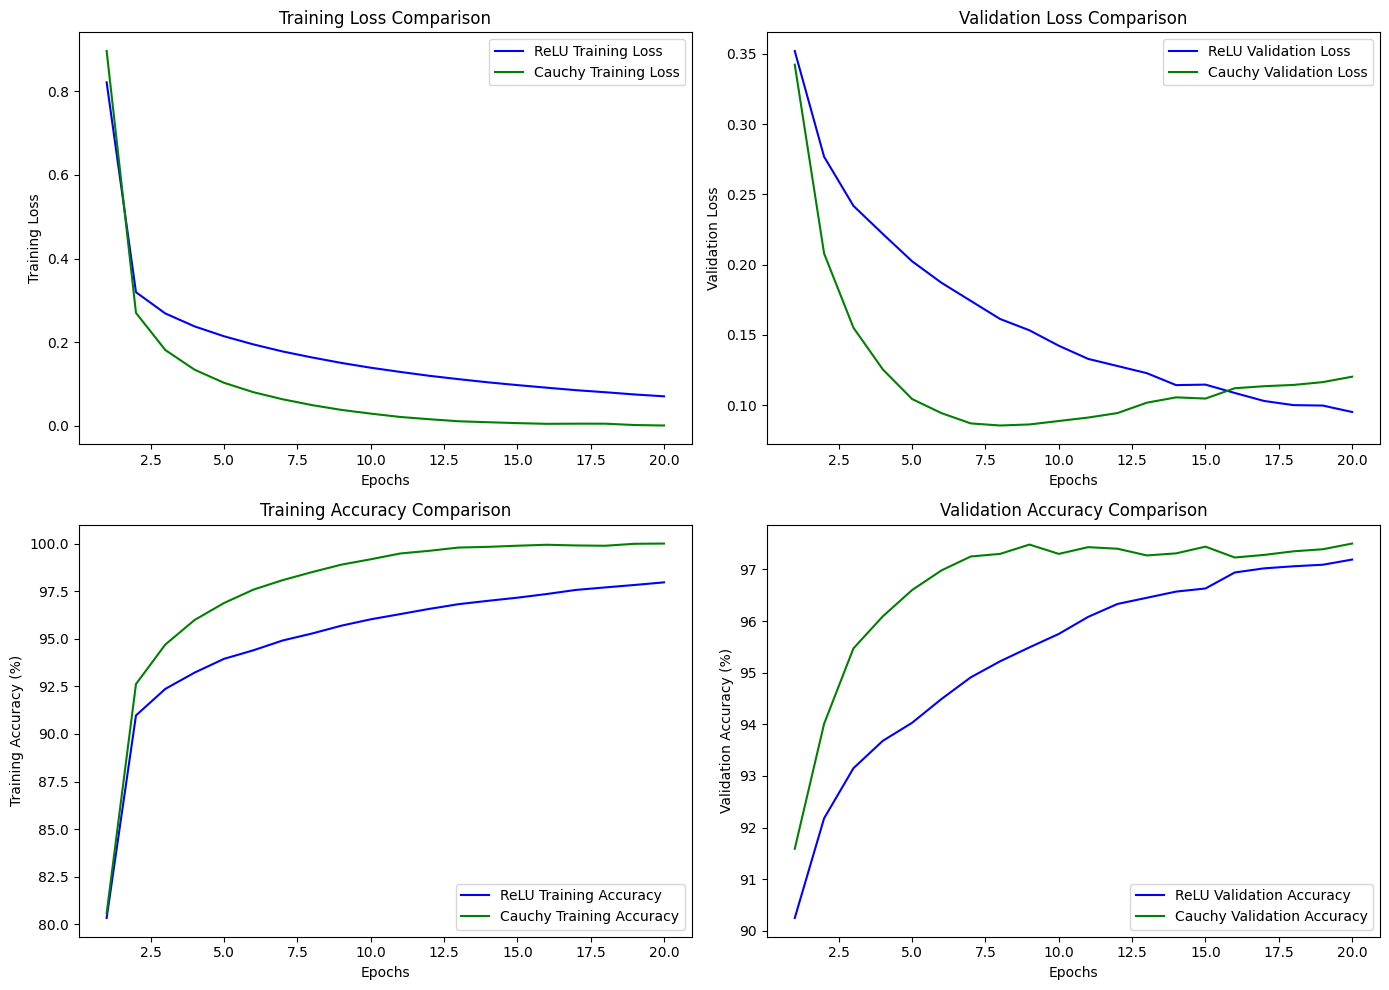

In [6]:
# Plotting the results
# Plotting metrics
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, relu_train_losses, 'b-', label='ReLU Training Loss')
plt.plot(epochs_range, cauchy_train_losses, 'g-', label='Cauchy Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Comparison')

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, relu_val_losses, 'b-', label='ReLU Validation Loss')
plt.plot(epochs_range, cauchy_val_losses, 'g-', label='Cauchy Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')

# Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs_range, relu_train_accuracies, 'b-', label='ReLU Training Accuracy')
plt.plot(epochs_range, cauchy_train_accuracies, 'g-', label='Cauchy Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.legend()
plt.title('Training Accuracy Comparison')

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs_range, relu_val_accuracies, 'b-', label='ReLU Validation Accuracy')
plt.plot(epochs_range, cauchy_val_accuracies, 'g-', label='Cauchy Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.tight_layout()
plt.show()